 ## Importing Libraries

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torchvision import transforms

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1) Paths & Hyperparameters

In [ ]:
# Paths for dataset and working directories
TRAIN_DIR = "/content/KVASIR_split/train"
TEST_DIR  = "/content/KVASIR_split/test"
WORKDIR   = "/content/hybrid_system"
MASK_DIR  = os.path.join(WORKDIR, "masks")      # Where masks will be saved
MODEL_PATH = os.path.join(WORKDIR, "hybrid_model.h5")  # Trained model file
U2NET_PTH = "/content/u2net.pth"               # Pretrained U²-Net weights

# Training parameters
IMG_SIZE = 224   # Input image size
BATCH = 8        # Batch size
EPOCHS = 20      # Number of epochs
LR = 1e-4        # Learning rate

# Create mask directory if it doesn't exist
os.makedirs(MASK_DIR, exist_ok=True)

## 2) Dataset Loader

In [ ]:
# 1. Extract dataset zip
zip_path = "/content/kvasir-dataset.zip"
extract_path = "/content"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("✅ Dataset extracted")

# 2. Set paths for base dataset and output split
base_dir = "/content/kvasir-dataset"    # Original dataset folder
output_dir = "/content/KVASIR_split"    # Where train/test will go
train_dir = os.path.join(output_dir, "train")
test_dir  = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
print("📂 Base directory:", base_dir)
print("📂 Classes found:", os.listdir(base_dir))

# 3. Split each class folder into train/test
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"\nProcessing class: {class_name}")

    images = [img for img in os.listdir(class_path)
              if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print("Total images:", len(images))
    if len(images) == 0:
        print("⚠️ Skipping empty folder.")
        continue

    # Split 80/20 train/test
    train_imgs, test_imgs = train_test_split(
        images, test_size=0.2, random_state=42
    )

    # Create class folders in train/test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy images to respective folders
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(train_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(test_dir, class_name, img))

    print(f"✅ {class_name} → Train: {len(train_imgs)}, Test: {len(test_imgs)}")

# 4. Done
print("\n🎉 SPLITTING COMPLETE!")
print("✅  Data split  is in: /content/KVASIR_split")

✅ Dataset extracted
📂 Base directory: /content/kvasir-dataset
📂 Classes found: ['kvasir-dataset', 'normal-cecum', 'dyed-lifted-polyps', 'normal-z-line', 'dyed-resection-margins', 'polyps', 'esophagitis', 'normal-pylorus', 'ulcerative-colitis']

Processing class: kvasir-dataset
Total images: 0
⚠️ Skipping empty folder.

Processing class: normal-cecum
Total images: 500
✅ normal-cecum → Train: 400, Test: 100

Processing class: dyed-lifted-polyps
Total images: 500
✅ dyed-lifted-polyps → Train: 400, Test: 100

Processing class: normal-z-line
Total images: 500
✅ normal-z-line → Train: 400, Test: 100

Processing class: dyed-resection-margins
Total images: 500
✅ dyed-resection-margins → Train: 400, Test: 100

Processing class: polyps
Total images: 500
✅ polyps → Train: 400, Test: 100

Processing class: esophagitis
Total images: 500
✅ esophagitis → Train: 400, Test: 100

Processing class: normal-pylorus
Total images: 500
✅ normal-pylorus → Train: 400, Test: 100

Processing class: ulcerative-col

In [ ]:
def build_df(DATASET_DIR):
    rows = []
    # Loop through each class folder in the dataset directory
    for cls in sorted(os.listdir(DATASET_DIR)):
        cls_dir = os.path.join(DATASET_DIR, cls)
        if not os.path.isdir(cls_dir): 
            continue  # Skip if not a directory
        # Loop through files in class folder
        for f in os.listdir(cls_dir):
            if f.lower().endswith(('.jpg', '.png', '.jpeg')):  # Only image files
                rows.append({
                    "filepath": os.path.join(cls_dir, f),  # Full path to image
                    "filename": f,                          # Image file name
                    "class": cls                             # Class label
                })
    return pd.DataFrame(rows)  # Convert list of dicts to DataFrame

# Build DataFrames for training and validation datasets
train_df = build_df(TRAIN_DIR)
val_df   = build_df(TEST_DIR)

# Get sorted list of class names and map to integer labels
classes = sorted(train_df['class'].unique())
class_map = {c: i for i, c in enumerate(classes)}

# Print dataset statistics
print(f"Train images: {len(train_df)} | Val images: {len(val_df)}")

Train images: 3200 | Val images: 800


## 3) Generating masks with U²-Net

In [ ]:
# Check if masks already exist
if len(os.listdir(MASK_DIR)) == 0:
    print("⚠️ Generating masks with U²-Net")

    # Clone U-2-Net repo if not already present
    if not os.path.exists("/content/U-2-Net"):
        !git clone -q https://github.com/xuebinqin/U-2-Net.git
    sys.path.append("/content/U-2-Net")

    from model import U2NET

    # Setup device and load pre-trained U²-Net model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    u2net = U2NET(3,1)
    u2net.load_state_dict(torch.load(U2NET_PTH, map_location=device))
    u2net.to(device).eval()

    # Define image transform for U²-Net input
    u2_transform = transforms.Compose([
        transforms.Resize((320,320)),
        transforms.ToTensor()
    ])

    # Function to predict mask from a PIL image
    def predict_mask(pil):
        x = u2_transform(pil).unsqueeze(0).to(device)
        with torch.no_grad():
            d1 = u2net(x)[0]  # model output
        m = d1[:,0,:,:].cpu().numpy().squeeze()
        # Normalize mask to 0-1
        return (m - m.min()) / (m.max() - m.min() + 1e-8)

    # Generate masks for training and validation images
    for df_ in [train_df, val_df]:
        for _, row in tqdm(df_.iterrows(), total=len(df_)):
            name = row['class'] + "_" + os.path.splitext(row['filename'])[0] + ".png"
            outp = os.path.join(MASK_DIR, name)
            if os.path.exists(outp): 
                continue  # Skip if mask already exists

            pil = Image.open(row['filepath']).convert("RGB")
            mask = predict_mask(pil)
            mask = cv2.resize(mask, pil.size)  # resize to original image size
            mask = (mask > 0.4).astype(np.uint8) * 255  # binarize mask
            cv2.imwrite(outp, mask)  # save mask

    print("✅ Masks generated")
else:
    print("✅ Masks already exist")

⚠️ Generating masks with U²-Net


  0%|          | 0/3200 [00:00<?, ?it/s]/content/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
100%|██████████| 800/800 [00:46<00:00, 17.04it/s]

✅ Masks generated


## 4) Data Generator with Augmentation

In [ ]:
class SegClassSequence(tf.keras.utils.Sequence):
    def __init__(self, df, augment=True, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)  # Reset DataFrame index
        self.aug = augment                   # Enable/disable augmentation
        self.idx = np.arange(len(df))        # Index array for shuffling

    def __len__(self):
        return int(np.ceil(len(self.df) / BATCH))  # Number of batches per epoch

    def on_epoch_end(self):
        np.random.shuffle(self.idx)  # Shuffle indices after each epoch

    def __getitem__(self, i):
        batch = self.idx[i*BATCH:(i+1)*BATCH]  # Get batch indices

        # Initialize batch arrays
        X = np.zeros((len(batch), IMG_SIZE, IMG_SIZE, 3), np.float32)  # Images
        ym = np.zeros((len(batch), IMG_SIZE, IMG_SIZE, 1), np.float32) # Masks
        yc = np.zeros((len(batch), len(classes)), np.float32)          # Class labels

        for j, k in enumerate(batch):
            r = self.df.loc[k]
            img = cv2.cvtColor(cv2.imread(r['filepath']), cv2.COLOR_BGR2RGB)  # Read image
            mask = cv2.imread(
                os.path.join(MASK_DIR, r['class'] + "_" + os.path.splitext(r['filename'])[0] + ".png"),
                cv2.IMREAD_GRAYSCALE
            )  # Read corresponding mask

            # Resize to model input size
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

            if self.aug:  # Apply data augmentation
                if np.random.rand() < 0.5:  # Horizontal flip
                    img = img[:, ::-1]
                    mask = mask[:, ::-1]

                # Random rotation
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((IMG_SIZE//2, IMG_SIZE//2), angle, 1)
                img = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
                mask = cv2.warpAffine(mask, M, (IMG_SIZE, IMG_SIZE))

                # Random brightness adjustment
                factor = 1 + (np.random.rand()-0.5)*0.2
                img = np.clip(img*factor, 0, 255)

            # Preprocess image for model
            X[j] = preprocess_input(img.astype(np.float32))
            ym[j,:,:,0] = (mask > 127).astype(np.float32)  # Binarize mask
            yc[j, class_map[r['class']]] = 1              # One-hot class label

        return X, {"class_output": yc, "mask_output": ym}  # Return batch

# Create training and validation sequences
train_seq = SegClassSequence(train_df, True)
val_seq   = SegClassSequence(val_df, False)

## 5) Hybrid Model with Regularization & Dropout

In [ ]:
# Input layer
inp = Input((IMG_SIZE, IMG_SIZE, 3))

# Base feature extractor (EfficientNetB0 pretrained on ImageNet)
base = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inp)

# Decoder for segmentation (mask prediction)
x = base.output
for f in [256,128,64,32,16]:
    x = UpSampling2D()(x)                                # Upsample spatially
    x = Conv2D(f, 3, padding="same", activation="relu", 
               kernel_regularizer=l2(1e-4))(x)          # Conv layer with L2 regularization
    x = BatchNormalization()(x)                           # Normalize activations
    x = Dropout(0.3)(x)                                   # Dropout for regularization

mask_out = Conv2D(1, 1, activation="sigmoid", name="mask_output")(x)  # Final mask output

# Classification head
g = GlobalAveragePooling2D()(base.output)                  # Global pooling of features
g = Dropout(0.5)(g)                                        # Dropout
g = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(g)  # Dense layer with L2
g = Dropout(0.5)(g)                                        # Dropout
class_out = Dense(len(classes), activation="softmax", name="class_output")(g)  # Class output

# Define model with dual outputs (classification + segmentation)
model = Model(inp, [class_out, mask_out])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 6) Compile Model

In [ ]:
# Dice coefficient metric for segmentation
def dice(y_true, y_pred):
    inter = tf.reduce_sum(y_true * y_pred)  # Intersection
    return (2*inter + 1e-6) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6)  # Dice score

# Compile hybrid model
model.compile(
    optimizer=Adam(LR),  # Optimizer
    loss={
        "class_output": "categorical_crossentropy",  # Classification loss
        # Segmentation loss = binary crossentropy + (1 - dice)
        "mask_output": lambda y,t: tf.keras.losses.binary_crossentropy(y,t) + (1-dice(y,t))
    },
    loss_weights={"class_output":1, "mask_output":2},  # Give mask loss higher weight
    metrics={"class_output":"accuracy", "mask_output":dice}  # Metrics for each output
)

## 7) Callbacks

In [ ]:
callbacks = [
    # Stop training early if validation accuracy doesn't improve
    EarlyStopping(
        monitor="val_class_output_accuracy",
        mode="max",
        patience=6,
        restore_best_weights=True
    ),
    
    # Reduce learning rate when validation accuracy plateaus
    ReduceLROnPlateau(
        monitor="val_class_output_accuracy",
        mode="max",
        patience=3,
        factor=0.5,
        min_lr=1e-6
    ),
    
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        MODEL_PATH,
        monitor="val_class_output_accuracy",
        mode="max",
        save_best_only=True
    )
]

## 8) Train Model

In [ ]:
# Load pretrained model weights if available
if os.path.exists(MODEL_PATH):
    model.load_weights(MODEL_PATH)

# Train the hybrid model
history = model.fit(
    train_seq,          # Training data generator
    validation_data=val_seq,  # Validation data generator
    epochs=EPOCHS,      # Number of epochs
    callbacks=callbacks # Callbacks for early stopping, LR reduction, checkpoint
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - class_output_accuracy: 0.3547 - class_output_loss: 1.6988 - loss: 3.0770 - mask_output_dice: 0.8096 - mask_output_loss: 0.6303

400/400 ━━━━━━━━━━━━━━━━━━━━ 176s 187ms/step - class_output_accuracy: 0.3551 - class_output_loss: 1.6977 - loss: 3.0750 - mask_output_dice: 0.8097 - mask_output_loss: 0.6299 - val_class_output_accuracy: 0.8487 - val_class_output_loss: 0.3920 - val_loss: 0.9918 - val_mask_output_dice: 0.9343 - val_mask_output_loss: 0.2413 - learning_rate: 1.0000e-04
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - class_output_accuracy: 0.7899 - class_output_loss: 0.5976 - loss: 1.2868 - mask_output_dice: 0.9159 - mask_output_loss: 0.2861

400/400 ━━━━━━━━━━━━━━━━━━━━ 66s 164ms/step - class_output_accuracy: 0.7900 - class_output_loss: 0.5975 - loss: 1.2866 - mask_output_dice: 0.9159 - mask_output_loss: 0.2861 - val_class_output_accuracy: 0.8938 - val_class_output_loss: 0.2856 - val_loss: 0.8140 - val_mask_output_dice: 0.9471 - val_mask_output_loss: 0.2061 - learning_rate: 1.0000e-04
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - class_output_accuracy: 0.8474 - class_output_loss: 0.4087 - loss: 0.9891 - mask_output_dice: 0.9356 - mask_output_loss: 0.2323

400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 163ms/step - class_output_accuracy: 0.8475 - class_output_loss: 0.4087 - loss: 0.9891 - mask_output_dice: 0.9356 - mask_output_loss: 0.2323 - val_class_output_accuracy: 0.8975 - val_class_output_loss: 0.2938 - val_loss: 0.7644 - val_mask_output_dice: 0.9522 - val_mask_output_loss: 0.1780 - learning_rate: 1.0000e-04
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - class_output_accuracy: 0.8836 - class_output_loss: 0.3272 - loss: 0.8480 - mask_output_dice: 0.9451 - mask_output_loss: 0.2033

400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - class_output_accuracy: 0.8836 - class_output_loss: 0.3272 - loss: 0.8480 - mask_output_dice: 0.9451 - mask_output_loss: 0.2033 - val_class_output_accuracy: 0.9050 - val_class_output_loss: 0.2596 - val_loss: 0.7059 - val_mask_output_dice: 0.9585 - val_mask_output_loss: 0.1667 - learning_rate: 1.0000e-04
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - class_output_accuracy: 0.9048 - class_output_loss: 0.2832 - loss: 0.8110 - mask_output_dice: 0.9465 - mask_output_loss: 0.2076

400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - class_output_accuracy: 0.9048 - class_output_loss: 0.2832 - loss: 0.8108 - mask_output_dice: 0.9465 - mask_output_loss: 0.2076 - val_class_output_accuracy: 0.9125 - val_class_output_loss: 0.2436 - val_loss: 0.6735 - val_mask_output_dice: 0.9623 - val_mask_output_loss: 0.1593 - learning_rate: 1.0000e-04
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - class_output_accuracy: 0.9016 - class_output_loss: 0.2605 - loss: 0.7103 - mask_output_dice: 0.9567 - mask_output_loss: 0.1695

400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 162ms/step - class_output_accuracy: 0.9016 - class_output_loss: 0.2605 - loss: 0.7103 - mask_output_dice: 0.9567 - mask_output_loss: 0.1695 - val_class_output_accuracy: 0.9225 - val_class_output_loss: 0.2236 - val_loss: 0.6249 - val_mask_output_dice: 0.9623 - val_mask_output_loss: 0.1459 - learning_rate: 1.0000e-04
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 64s 161ms/step - class_output_accuracy: 0.9190 - class_output_loss: 0.2297 - loss: 0.6736 - mask_output_dice: 0.9569 - mask_output_loss: 0.1674 - val_class_output_accuracy: 0.9112 - val_class_output_loss: 0.2286 - val_loss: 0.6140 - val_mask_output_dice: 0.9674 - val_mask_output_loss: 0.1389 - learning_rate: 1.0000e-04
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 64s 159ms/step - class_output_accuracy: 0.9140 - class_output_loss: 0.2076 - loss: 0.6038 - mask_output_dice: 0.9633 - mask_output_loss: 0.1445 - val_class_output_accuracy: 0.9013 - val_class_output_loss: 0.3525 - val_loss: 0.7412 - val_mask_output_

## 9) Training Graphs

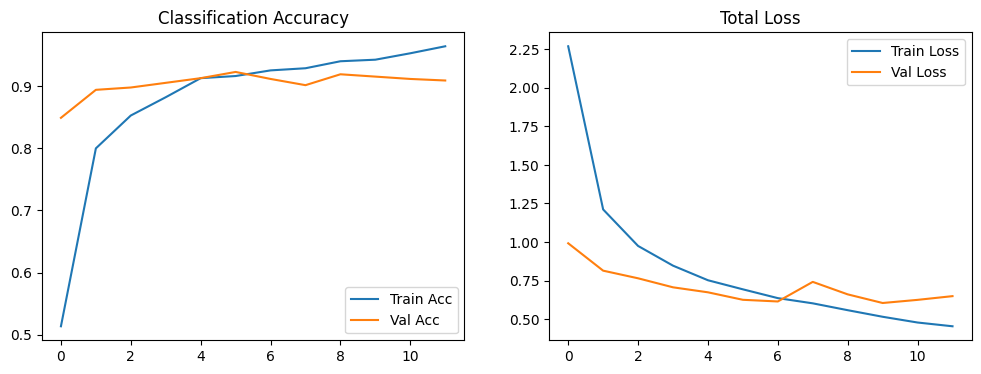

In [ ]:
plt.figure(figsize=(12,4))

# Plot classification accuracy
plt.subplot(1,2,1)
plt.plot(history.history['class_output_accuracy'], label='Train Acc')
plt.plot(history.history['val_class_output_accuracy'], label='Val Acc')
plt.legend()
plt.title("Classification Accuracy")

# Plot total loss (combined for both outputs)
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Total Loss")

plt.show()

## 10) Confusion Matrix

100%|██████████| 800/800 [01:15<00:00, 10.58it/s]


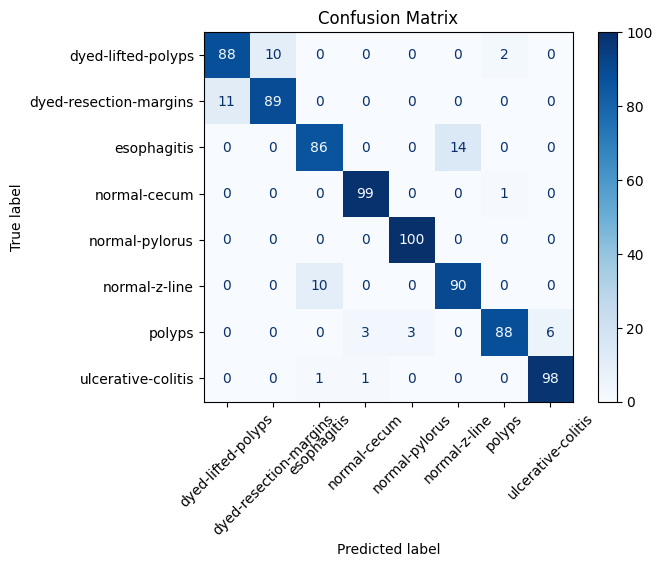

In [ ]:
y_true, y_pred = [], []

# Predict classes on validation set
for _, row in tqdm(val_df.iterrows(), total=len(val_df)):
    img = cv2.cvtColor(cv2.imread(row['filepath']), cv2.COLOR_BGR2RGB)  # Read image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))                           # Resize
    img = np.expand_dims(preprocess_input(img.astype(np.float32)), 0)    # Preprocess and add batch dim

    class_pred, _ = model.predict(img, verbose=0)                         # Get prediction
    y_true.append(row['class'])                                           # True label
    y_pred.append(classes[np.argmax(class_pred)])                         # Predicted label

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

## 11) Grad-CAM Function

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def get_gradcam_fixed(model, img_path, classes, IMG_SIZE=224):
    # Load and preprocess image
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    orig = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    input_img = np.expand_dims(orig.astype(np.float32), 0)
    input_img = tf.keras.applications.efficientnet.preprocess_input(input_img)

    # Predict class
    class_pred, _ = model.predict(input_img, verbose=0)
    class_idx = np.argmax(class_pred[0])
    print(f"🔍 Getting Grad-CAM for class: {classes[class_idx]} (index: {class_idx})")

    # Find convolutional layers
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name.lower()]
    for layer in conv_layers:
        print(f"  Found conv layer: {layer.name}")

    # Choose last conv layer (fallbacks if not found)
    if conv_layers:
        last_conv_layer = conv_layers[-1]
        print(f"✅ Using convolutional layer: {last_conv_layer.name}")
    else:
        stem_layers = [layer for layer in model.layers if 'stem' in layer.name.lower()]
        if stem_layers:
            last_conv_layer = stem_layers[-1]
            print(f"✅ Using stem layer: {last_conv_layer.name}")
        else:
            mid_idx = len(model.layers) // 2
            last_conv_layer = model.layers[mid_idx]
            print(f"⚠️ Using middle layer: {last_conv_layer.name} (index {mid_idx})")

    # Build Grad-CAM model
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.get_layer("class_output").output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_img)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)

    # Handle None gradients
    if grads is None:
        print("⚠️ Gradients are None. Returning basic visualization.")
        heatmap_resized = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        overlay = orig.astype(np.uint8)
        return heatmap_resized, overlay

    # Compute Grad-CAM
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = tf.reduce_sum(conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val > 0:
        heatmap = heatmap / max_val
    heatmap = heatmap.numpy()

    # Resize and apply colormap
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    overlay = cv2.addWeighted(orig.astype(np.uint8), 0.6, heatmap_color, 0.4, 0)

    return heatmap_resized, overlay

## 12) Simplified Analysis Function

In [ ]:
def analyze_image_simple(model, img_path, classes, IMG_SIZE=224):
    # Load and preprocess image
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    orig = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    input_img = np.expand_dims(orig.astype(np.float32), 0)
    input_img = tf.keras.applications.efficientnet.preprocess_input(input_img)

    # Predict class and segmentation mask
    class_pred, mask_pred = model.predict(input_img, verbose=0)
    pred_class = classes[np.argmax(class_pred)]           # Predicted class
    pred_confidence = np.max(class_pred[0])              # Confidence
    mask_pred = mask_pred[0]

    # Binarize mask
    mask_bin = (mask_pred[:,:,0] > 0.5).astype(np.uint8) * 255

    # Find contours in mask
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Take largest contour and compute bounding box
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        area = cv2.contourArea(largest_contour)

        # Draw bounding box on image
        img_bbox = orig.copy()
        cv2.rectangle(img_bbox, (x, y), (x+w, y+h), (0, 255, 0), 2)
    else:
        area = 0
        img_bbox = orig.copy()

    # Return results as dictionary
    return {
        "pred_class": pred_class,
        "pred_confidence": pred_confidence,
        "mask": mask_bin,
        "bbox_image": img_bbox,
        "area_pixels": area,
        "original_image": orig
    }

## 13) Performance Evaluation

In [ ]:
print("📊 MODEL PERFORMANCE EVALUATION")
print("=" * 50)

# Initialize counters
correct = 0
total = len(val_df)

# Loop through validation images
for idx, row in val_df.iterrows():
    img_path = row['filepath']
    true_class = row['class']

    # Load and preprocess image
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(img.astype(np.float32), 0)
    input_img = tf.keras.applications.efficientnet.preprocess_input(input_img)

    # Predict class
    class_pred, _ = model.predict(input_img, verbose=0)
    pred_class = classes[np.argmax(class_pred[0])]

    # Count correct predictions
    if pred_class == true_class:
        correct += 1

# Compute overall accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2%} ({correct}/{total})")
print()


📊 MODEL PERFORMANCE EVALUATION
Test Accuracy: 92.25% (738/800)



## 14) Analyze Misclassifications

🔍 ANALYZING MISCLASSIFICATIONS
Found 62 misclassified images (7.8%)

📸 Examples of misclassifications:
  1. True: dyed-lifted-polyps → Pred: dyed-resection-margins (conf: 94.84%)
  2. True: dyed-lifted-polyps → Pred: dyed-resection-margins (conf: 99.74%)
  3. True: dyed-lifted-polyps → Pred: dyed-resection-margins (conf: 94.29%)


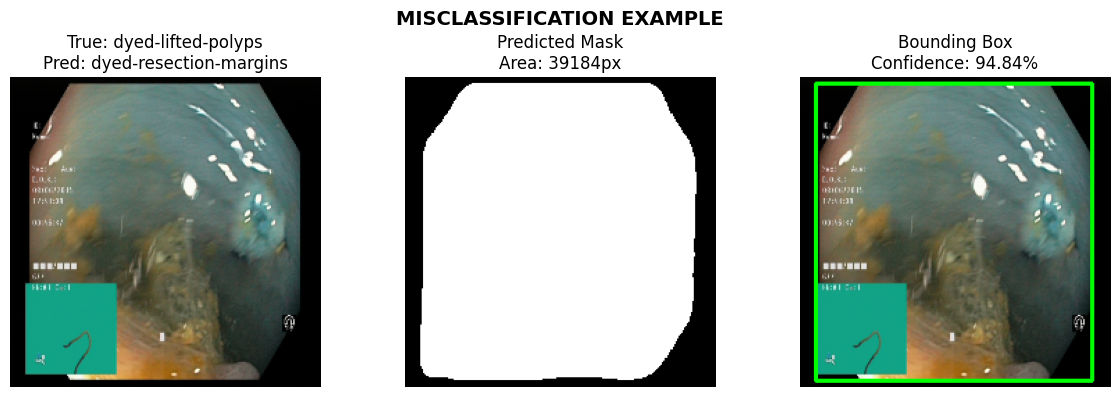

In [ ]:
print("🔍 ANALYZING MISCLASSIFICATIONS")
print("=" * 50)

# Find all misclassified images
misclassified = []
for idx, row in val_df.iterrows():
    img_path = row['filepath']
    true_class = row['class']

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(img.astype(np.float32), 0)
    input_img = tf.keras.applications.efficientnet.preprocess_input(input_img)

    class_pred, _ = model.predict(input_img, verbose=0)
    pred_class = classes[np.argmax(class_pred[0])]
    confidence = np.max(class_pred[0])

    if pred_class != true_class:
        misclassified.append({
            'idx': idx,
            'true_class': true_class,
            'pred_class': pred_class,
            'confidence': confidence,
            'img_path': img_path
        })

print(f"Found {len(misclassified)} misclassified images ({len(misclassified)/total:.1%})")
print()

# Show some misclassifications
if misclassified:
    print("📸 Examples of misclassifications:")
    for i in range(min(3, len(misclassified))):
        mc = misclassified[i]
        print(f"  {i+1}. True: {mc['true_class']} → Pred: {mc['pred_class']} (conf: {mc['confidence']:.2%})")

    # Visualize first misclassification
    mc = misclassified[0]
    results = analyze_image_simple(model, mc['img_path'], classes)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(results['original_image'])
    plt.title(f"True: {mc['true_class']}\nPred: {results['pred_class']}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(results['mask'], cmap='gray')
    plt.title(f"Predicted Mask\nArea: {results['area_pixels']:.0f}px")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(results['bbox_image'])
    plt.title(f"Bounding Box\nConfidence: {results['pred_confidence']:.2%}")
    plt.axis('off')

    plt.suptitle(f"MISCLASSIFICATION EXAMPLE", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 15) Per-Class Performance

In [ ]:
print("\n📈 PER-CLASS PERFORMANCE")
print("=" * 50)

# Initialize counters for each class
class_stats = {cls: {'total': 0, 'correct': 0} for cls in classes}

# Loop through validation images
for idx, row in val_df.iterrows():
    true_class = row['class']
    class_stats[true_class]['total'] += 1

    # Load and preprocess image
    img_path = row['filepath']
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(img.astype(np.float32), 0)
    input_img = tf.keras.applications.efficientnet.preprocess_input(input_img)

    # Predict class
    class_pred, _ = model.predict(input_img, verbose=0)
    pred_class = classes[np.argmax(class_pred[0])]

    # Count correct predictions per class
    if pred_class == true_class:
        class_stats[true_class]['correct'] += 1

# Print class-wise accuracy
print(f"{'Class':<25} {'Accuracy':<10} {'Count':<10}")
print("-" * 50)
for cls in classes:
    total = class_stats[cls]['total']
    correct = class_stats[cls]['correct']
    if total > 0:
        accuracy = correct / total
        print(f"{cls:<25} {accuracy:.2%}     {correct}/{total}")
    else:
        print(f"{cls:<25} N/A        0/0")


📈 PER-CLASS PERFORMANCE
Class                     Accuracy   Count     
--------------------------------------------------
dyed-lifted-polyps        88.00%     88/100
dyed-resection-margins    89.00%     89/100
esophagitis               86.00%     86/100
normal-cecum              99.00%     99/100
normal-pylorus            100.00%     100/100
normal-z-line             90.00%     90/100
polyps                    88.00%     88/100
ulcerative-colitis        98.00%     98/100


## 16) Test Correct Predictions Too


✅ EXAMPLES OF CORRECT PREDICTIONS


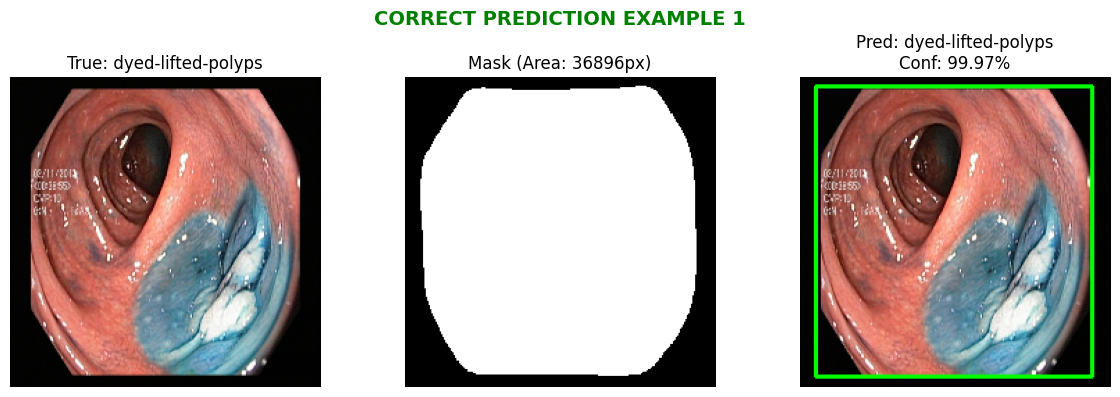

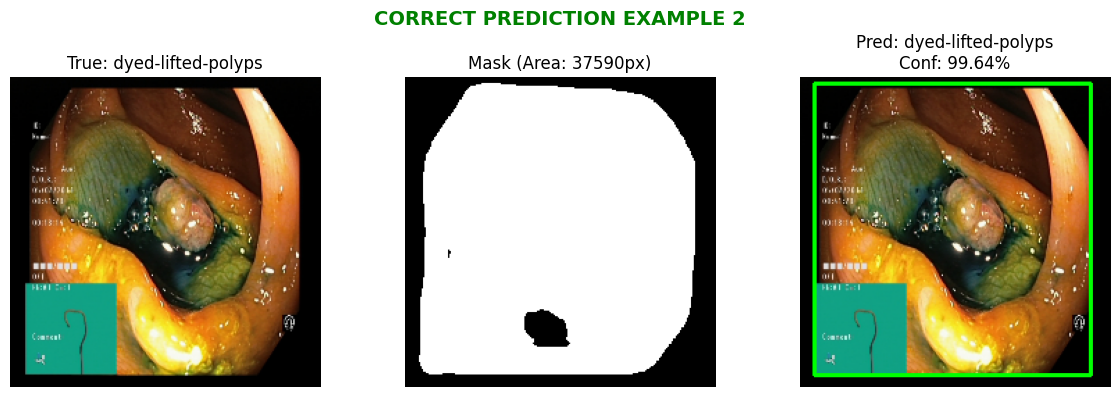

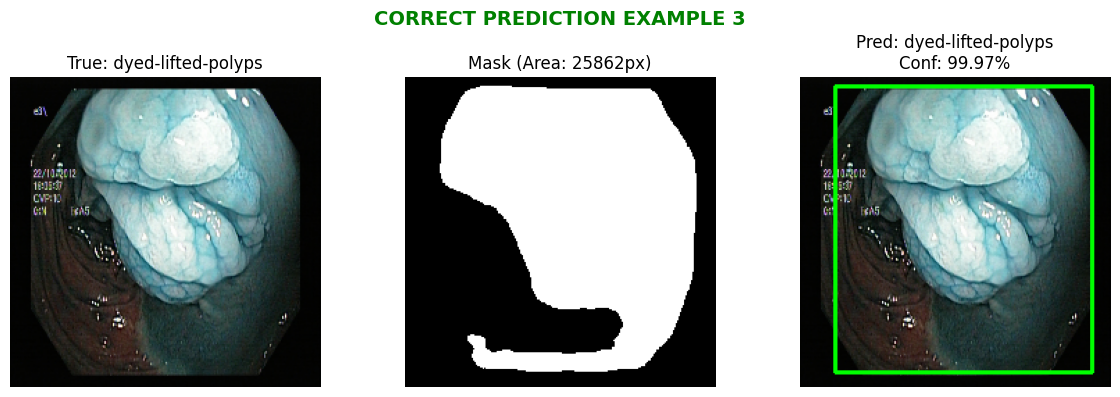

In [ ]:
print("\n✅ EXAMPLES OF CORRECT PREDICTIONS")
print("=" * 50)

# Collect a few correct predictions
correct_predictions = []
for idx, row in val_df.iterrows():
    if len(correct_predictions) >= 3:
        break

    true_class = row['class']
    img_path = row['filepath']

    # Load and preprocess image
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(img.astype(np.float32), 0)
    input_img = tf.keras.applications.efficientnet.preprocess_input(input_img)

    # Predict class
    class_pred, _ = model.predict(input_img, verbose=0)
    pred_class = classes[np.argmax(class_pred[0])]

    # Save correct predictions
    if pred_class == true_class:
        correct_predictions.append({
            'idx': idx,
            'true_class': true_class,
            'img_path': img_path,
            'confidence': np.max(class_pred[0])
        })

# Visualize examples with mask and bounding box
for i, cp in enumerate(correct_predictions):
    results = analyze_image_simple(model, cp['img_path'], classes)

    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(results['original_image'])
    plt.title(f"True: {cp['true_class']}")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(results['mask'], cmap='gray')
    plt.title(f"Mask (Area: {results['area_pixels']:.0f}px)")
    plt.axis('off')

    # Bounding box overlay
    plt.subplot(1, 3, 3)
    plt.imshow(results['bbox_image'])
    plt.title(f"Pred: {results['pred_class']}\nConf: {results['pred_confidence']:.2%}")
    plt.axis('off')

    plt.suptitle(f"CORRECT PREDICTION EXAMPLE {i+1}", fontsize=14, fontweight='bold', color='green')
    plt.tight_layout()
    plt.show()
